# Sequence to Sequence Learning with Neural Networks
___

This notebook represents an implementation of the model described in the referenced paper, which can be accessed [here](https://arxiv.org/pdf/1409.3215v3).

The model's architecture is detailed in the **Seq2Seq Model** section, with direct citations from the original paper to ensure accuracy.

Training was conducted over $5$ epochs, achieving a final validation loss of approximately $1.00$. This training information is not visible in this notebook due to constraints on output display. Additionally, the computation of the *BLEU* score remains to be incorporated.

<small>Note: Certain special characters used for denoting the beginning and end of sentences, as well as padding—specifically the '\<' and '\>' symbols—do not display correctly after uploading to GitHub, appearing as empty strings instead.</small>

---

## 1. Libraries

In [135]:
import os
import re
import random
from typing import List

import spacy
import torch
import torchtext
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from torchtext.data.metrics import bleu_score


# Controlling the randomness in PyTorch and NumPy.
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.benchmark = True
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

## 2. The Dataset
I've used a Kaggle dataset. You can download it from [here](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench).

In [136]:
DATASET_PATH = os.path.join(
    "..", 
    "..", 
    "nlp", 
    "datasets", 
    "en-fr-translation", 
    "en-fr.csv"
)

df = pd.read_csv(DATASET_PATH)
df = df.rename(columns={"English words/sentences": "EN"})
df = df.rename(columns={"French words/sentences": "FR"})

df.head()

,EN,FR
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [137]:
def prepare_sentence(sentence: str):
    pattern = r"([.,!?:;]+)"
    sentence = re.sub(pattern, r" \1 ", sentence)

    pattern = r"\s+"
    sentence = re.sub(pattern, " ", sentence)

    return sentence

array([[<AxesSubplot:title={'center':'EN word count'}>,
        <AxesSubplot:title={'center':'FR word count'}>]], dtype=object)

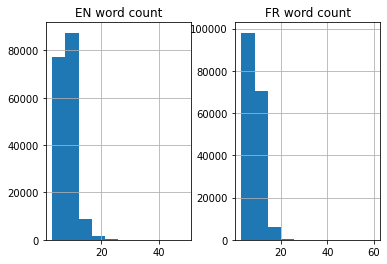

In [138]:
df["EN word count"] = df["EN"].apply(lambda x: len(prepare_sentence(x).split(" ")))
df["FR word count"] = df["FR"].apply(lambda x: len(prepare_sentence(x).split(" ")))
df.hist()

As we can see from the distributions, in both languages it would be okay to select $20$ as the max size of an input/output sequence.

In [139]:
# Shuffling and generating a subsample of the dataframe.
DATASET_FRACTION = 0.5
df = df.sample(frac=DATASET_FRACTION)

In [140]:
# You should first download these two spaCy models!
en_tokenizer = get_tokenizer("spacy", "en_core_web_sm")
fr_tokenizer = get_tokenizer("spacy", "fr_core_news_sm")

In [141]:
def iterate_corpus(corpus: List[str], tokenizer: spacy.tokenizer.Tokenizer, max_len: int):
    for sentence in corpus:
        tokens = tokenizer(
            prepare_sentence(sentence)
        )

        # Adding padding if it is needed.
        if len(tokens) >= max_len:
            tokens = tokens[:max_len]
        else:
            len_diff = max_len - len(tokens)
            tokens = tokens + ["<pad>"] * len_diff

        yield tokens


en_corpus = [sent for sent in list(df["EN"])]
fr_corpus = [sent for sent in list(df["FR"])]
EN_MAX_LEN = 20
FR_MAX_LEN = 20
SPECIALS = ["<unk>", "<start>", "<end>", "<pad>"]

en_vocab = build_vocab_from_iterator(
    iterate_corpus(en_corpus, en_tokenizer, EN_MAX_LEN), 
    specials=SPECIALS
)
en_vocab.set_default_index(en_vocab["<unk>"])

fr_vocab = build_vocab_from_iterator(
    iterate_corpus(fr_corpus, fr_tokenizer, FR_MAX_LEN), 
    specials=SPECIALS
)
fr_vocab.set_default_index(fr_vocab["<unk>"])

In [142]:
class TranslationDataset(Dataset):

    def __init__(
        self, 
        lang1_corpus: List[str], lang2_corpus: List[str],
        lang1_tokenizer: spacy.tokenizer.Tokenizer, lang2_tokenizer: spacy.tokenizer.Tokenizer,
        lang1_vocab: torchtext.vocab.Vocab, lang2_vocab: torchtext.vocab.Vocab,
        lang1_max_len: int = 200, lang2_max_len: int = 200, special_tokens=SPECIALS
    ):
        self.l1_corpus = lang1_corpus
        self.l2_corpus = lang2_corpus

        self.l1_max_len = lang1_max_len
        self.l2_max_len = lang2_max_len
        
        self.l1_tokenizer = lang1_tokenizer
        self.l2_tokenizer = lang2_tokenizer
        
        self.l1_vocab = lang1_vocab
        self.l2_vocab = lang2_vocab

        self.l1_token2idx = lang1_vocab
        self.l1_idx2token = {
            lang1_vocab[word]: word
            for sentence in lang1_corpus
            for word in lang1_tokenizer(prepare_sentence(sentence)) + SPECIALS
        }
        self.l2_token2idx = lang2_vocab
        self.l2_idx2token = {
            lang2_vocab[word]: word
            for sentence in lang2_corpus
            for word in lang2_tokenizer(prepare_sentence(sentence)) + SPECIALS
        }

        self.x, self.y = self._get_x_y()

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

    def _get_x_y(self):
        x = TranslationDataset._parse_corpus(
            self.l1_corpus, self.l1_tokenizer, self.l1_vocab, self.l1_max_len
        )
        y = TranslationDataset._parse_corpus(
            self.l2_corpus, self.l2_tokenizer, self.l2_vocab, self.l2_max_len
        )

        return x, y

    @staticmethod
    def _parse_corpus(
        corpus: List[str], 
        tokenizer: spacy.tokenizer.Tokenizer, 
        vocab: torchtext.vocab.Vocab,
        max_len: int
    ):
        output = []

        for sent in corpus:
            tokens = tokenizer(sent)
            indices = [vocab[token] for token in tokens]
            if len(indices) >= max_len:
                output.append([vocab["<start>"]] + indices[:max_len] + [vocab["<end>"]])
            else:
                len_diff = max_len - len(indices)
                padding = [vocab["<pad>"]] * len_diff
                output.append([vocab["<start>"]] + indices + [vocab["<end>"]] + padding)

        return torch.LongTensor(output)


dataset = TranslationDataset(
    lang1_corpus=en_corpus, lang2_corpus=fr_corpus,
    lang1_vocab=en_vocab, lang2_vocab=fr_vocab,
    lang1_tokenizer=en_tokenizer, lang2_tokenizer=fr_tokenizer,
    lang1_max_len=EN_MAX_LEN, lang2_max_len=FR_MAX_LEN
)
# Printing an example sentence, using the l1_idx2token dictionary.
# l1 here means language 1, which is English.
x_sample = dataset.x[1]
print("Using the 'l1_idx2token' attribute:")
print([dataset.l1_idx2token[int(idx)] for idx in x_sample])

print("x.shape:", dataset.x.shape)
print("y.shape:", dataset.y.shape)

Using the 'l1_idx2token' attribute:
['<start>', 'I', "'m", 'not', 'that', 'cynical', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
x.shape: torch.Size([87810, 22])
y.shape: torch.Size([87810, 22])


In [143]:
def train_validation_split(dataset: torch.utils.data.Dataset, train_size: float):
    train_set_size = int(len(dataset) * train_size)
    valid_set_size = len(dataset) - train_set_size
    datasets_lengths = [train_set_size, valid_set_size]

    # Splitting the input dataset into training and validation set.
    train_dataset, valid_dataset = random_split(dataset, datasets_lengths)

    return train_dataset, valid_dataset


train_dataset, valid_dataset = train_validation_split(
    dataset, train_size=0.8
)
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(valid_dataset))

Training dataset size: 70248
Validation dataset size: 17562


## 3. Seq2Seq Model
The architecture of this model features two primary components, both based on *LSTM* structures: an *Encoder* and a *Decoder*.

- **Encoder**: This component is responsible for processing the input sequence. It first embeds the sequence into a specific space, then passes it through LSTM cells. It outputs not only the final layer's outputs but crucially, the *hidden state*, which is essential for the Decoder's operations.
- **Decoder**: Leveraging the *hidden state* received from the Encoder, the Decoder processes the target sequence token by token. During inference, only the '*\<start\>*' token is initially provided, and the model generates subsequent tokens one at a time. The Decoder mirrors the Encoder in structure but includes an additional final layer that maps outputs to a vector in $\mathbb{R}^{vocab}$, representing the vocabulary size (in this case, French).

A notable technique implemented from the research paper is the reversal of the input sequence before it reaches the Encoder:
> ... we found
> it extremely valuable to reverse the order of the words of the input sentence. For example,
> rather than mapping the sentence 'a, b, c' to 'α, β, γ', the LSTM is tasked with mapping 'c, b, a' to 'α, β, γ',
> where 'α, β, γ' translates 'a, b, c'. This arrangement places 'a' near 'α', 'b' close to 'β', and so on, which facilitates easier learning connections for SGD between the input and the output.

Additionally, the Decoder employs *teacher forcing* at a defined probability, determining how often the ground truth values are fed back as input during training.

These components and strategies are integrated within the `Seq2Seq` class's `forward()` method.

### 3.1. Encoder

In [144]:
class Encoder(nn.Module):

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, num_layers: int, padding_idx: int):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            input_size=embed_size, 
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

    def forward(self, x: torch.Tensor):
        embedded_x = self.embed(x)
        out, hidden = self.lstm(embedded_x)

        return out, hidden


x = torch.randint(low=0, high=20, size=(10, 5))
enc = Encoder(vocab_size=50, embed_size=100, hidden_size=100, num_layers=4, padding_idx=0)
out, hidden = enc(x)
print(f"Encoder output shape: {out.shape}")

Encoder output shape: torch.Size([10, 5, 100])


### 3.2. Decoder

In [145]:
class Decoder(nn.Module):

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, num_layers: int, padding_idx: int):
        super().__init__()
        self.vocab_size = vocab_size

        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            input_size=embed_size, 
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, x: torch.Tensor, hidden: tuple):
        x = x.unsqueeze(0)
        x = x.reshape((x.shape[1], x.shape[0]))

        embedded_x = self.embed(x)

        hidden = [state.detach() for state in hidden]
        out, hidden = self.lstm(embedded_x, hidden)
        out = self.project(out)

        return out, hidden


# Passing through the Encoder
x = torch.randint(low=0, high=20, size=(10, 5))
enc = Encoder(vocab_size=50, embed_size=100, hidden_size=150, num_layers=4, padding_idx=0)
out, hidden = enc(x)
print(f"Encoder output shape: {out.shape}")
y = torch.randint(low=0, high=40, size=(10, 5))
# Sending only the start token to the Decoder.
curr_input = y[:, 0]
print(f"Curr. input shape: {curr_input.shape}")

# Passing through the Decoder
dec = Decoder(vocab_size=200, embed_size=100, hidden_size=150, num_layers=4, padding_idx=0)
out, hidden = dec(curr_input, hidden)
print(f"Decoder output shape: {out.shape}")

Encoder output shape: torch.Size([10, 5, 150])
Curr. input shape: torch.Size([10])
Decoder output shape: torch.Size([10, 1, 200])


### 3.3. Seq2Seq

In [146]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder: torch.nn.Module, decoder: torch.nn.Module, reverse_input=True, device="cpu"):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder

        self.reverse_input = reverse_input
        self.device = device

    def forward(self, x: torch.Tensor, y: torch.Tensor, teacher_forcing_ratio=0.5):
        batch_size, tgt_len = y.shape[0], y.shape[1]
        vocab_size = self.decoder.vocab_size

        # Tensor in which we are going to store the Decoder outputs.
        outputs = torch.zeros(size=(batch_size, tgt_len, vocab_size)).to(self.device)

        # Reversing the sequences in the input tensor.
        # In the paper it's stated that it is extremely valuable, and makes a difference.
        if self.reverse_input:
            x = torch.flip(x, [1])
        
        # Here, since the encoder output is not going to be used, I declare it
        # as '_'.
        _, hidden = self.encoder(x)

        # The start token:
        curr_input = y[:, 0]

        for t in range(1, tgt_len):
            out, hidden = self.decoder(curr_input, hidden)
            out = out.squeeze(1)

            outputs[:, t, :] = out

            teacher_force = teacher_forcing_ratio > random.random()

            # Getting the top prediction.
            top_pred = out.argmax(1)

            # If we are in a teacher forcing state - use actual next token
            # as an input to the Decoder, else - use the top prediction.
            curr_input = y[:, t] if teacher_force else top_pred

        return outputs


# Input tensor:
x = torch.randint(low=0, high=20, size=(10, 5))
y = torch.randint(low=0, high=40, size=(10, 5))

# Defining the Encoder:
enc = Encoder(vocab_size=50, embed_size=100, hidden_size=150, num_layers=4, padding_idx=0)

# Defining the decoder:
dec = Decoder(vocab_size=100, embed_size=100, hidden_size=150, num_layers=4, padding_idx=0)

# Creating the Seq2Seq model:
model = Seq2Seq(encoder=enc, decoder=dec)
out = model(x, y)

print(f"Model:\n{model}")

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

print(f"Seq2Seq output shape: {out.shape}")

Model:
Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(50, 100, padding_idx=0)
    (lstm): LSTM(100, 150, num_layers=4, batch_first=True)
  )
  (decoder): Decoder(
    (embed): Embedding(100, 100, padding_idx=0)
    (lstm): LSTM(100, 150, num_layers=4, batch_first=True)
    (project): Linear(in_features=150, out_features=100, bias=True)
  )
)
x shape: torch.Size([10, 5])
y shape: torch.Size([10, 5])
Seq2Seq output shape: torch.Size([10, 5, 100])


In [147]:
def initialize_weights(model: torch.nn.Module):
    """Initializing the weights with the uniform distribution between -0.08 and 
    0.08.

    Args:
        model (torch.nn.Module): The model for which the weights will be initialized.
    """
    for name, param in model.named_parameters():
        if "bias" in name or "weight" in name:
            torch.nn.init.uniform_(param, a=-0.08, b=0.08)

In [148]:
def save_checkpoint(model: torch.nn.Module, path: str):
    torch.save(model.state_dict(), path)


def load_checkpoint(model: torch.nn.Module, path: str):
    model.load_state_dict(torch.load(path))
    return model


MODEL_FILENAME = "1-seq2seq.pt"
MODEL_PATH = os.path.join("..", "models", MODEL_FILENAME)

## 4. Training
The training process outlined in this implementation slightly deviates from the methods described in the original paper, though these differences are minimal.

The paper specifies the use of a *uniform distribution* for initializing weights:
> We initialized all of the LSTM’s parameters with the uniform distribution between -0.08 and 0.08.

This initialization is replicated in the `initialize_weights()` function mentioned earlier.

> We used stochastic gradient descent without momentum, with a fixed learning rate of 0.7. After 5 epochs, we began halving the learning rate every half epoch. We trained our models for a total of 7.5 epochs.

In contrast, this implementation employs the SGD optimizer with an initial learning rate of $0.7$. However, the strategy of halving the learning rate every half epoch is not implemented here.

> We used batches of 128 sequences.

Due to constraints related to VRAM capacity, this implementation uses a smaller batch size of $64$.

> Although LSTMs tend to not suffer from the vanishing gradient problem, they can have exploding gradients. Thus we enforced a hard constraint on the norm of the gradient [10, 25] by scaling it when its norm exceeded a threshold.

Similar to the paper, this implementation includes gradient clipping to prevent exploding gradients, utilizing the `torch.nn.utils.clip_grad_norm_()` method as detailed in the `Seq2SeqTrainingSession._train_epoch()`.

Lastly, consistent with the paper, the model undergoes training for $5$ epochs.

In [149]:
%%capture cap --no-stderr


class Seq2SeqTrainingSession:

    def __init__(
        self, 
        model: torch.nn.Module, 
        loss: torch.nn.Module, 
        optimizer: torch.optim.Optimizer,
        epochs: int, batch_size: int, 
        use_clipping=True,
        device="cpu"
    ):
        self.model = model
        self.loss_func = loss
        self.optimizer = optimizer

        self.epochs = epochs
        self.batch_size = batch_size

        self.use_clipping = use_clipping
        self.clip = 5
        self.device = device

    def start(
        self, 
        train_dataset: torch.utils.data.Subset, 
        valid_dataset: torch.utils.data.Subset,
        l1_idx2token: dict,
        l2_idx2token: dict,
        fixed_sentences: List[List[str]] = None
    ):
        self.fixed_sentences = fixed_sentences

        self.l1_idx2token = l1_idx2token
        self.l2_idx2token = l2_idx2token
        
        train_dataloader = DataLoader(
            train_dataset, 
            self.batch_size, 
            shuffle=True, 
            num_workers=0,
            drop_last=True
        )
        valid_dataloader = DataLoader(
            valid_dataset, 
            self.batch_size, 
            shuffle=True, 
            num_workers=0,
            drop_last=True
        )
        
        for epoch in range(self.epochs):
            train_loss = self._train_epoch(train_dataloader)
            valid_loss = self._valid_epoch(valid_dataloader)
            print(f"Epoch: {epoch + 1}, Training Loss: {train_loss:.2f}, Validation Loss: {valid_loss:.2f}")

        return self.model

    def _train_epoch(self, dataloader):

        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(self.device), y.to(self.device)

            y_pred = self.model(x, y)

            # Here y_pred should be trasformed to shape (BATCH_SIZE * SEQ_LEN, VOCAB_SIZE)
            # and y should be transformed to shape (BATCH_SIZE * SEQ_LEN).
            loss = self.loss_func(y_pred.reshape((-1, y_pred.shape[-1])), y.reshape(-1))
            self.optimizer.zero_grad()

            loss.backward()

            # Clipping the gradients, since LSTMs can have exploding gradients.
            if self.use_clipping:
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), 
                    max_norm=self.clip
                )

            self.optimizer.step()

            if batch_i % 150 == 0:
                pred_sents, target_sents = self._tensors2sentences(y_pred[:1], y[:1])
                print(f"Training Batch {batch_i}, Loss: {loss.item():.2f}")
                print("Example")
                print("-" * 100)
                print(f"Target: {' '.join(target_sents)}")
                print(f"Prediction: {' '.join(pred_sents)}")
                print("-" * 100)

                # Saving the model checkpoint.
                save_checkpoint(model=self.model, path=MODEL_PATH)

        epoch_loss = loss.item()
        # TODO: Fix the calculation of BLEU.
        # epoch_bleu = self._calc_bleu(y_pred, y)

        return epoch_loss

    def _valid_epoch(self, dataloader):

        self.model.eval()

        with torch.no_grad():
            for batch_i, (x, y) in enumerate(dataloader):
                x, y = x.to(self.device), y.to(self.device)
            
                y_pred = self.model(x, y)

                loss = self.loss_func(y_pred.reshape((-1, y_pred.shape[-1])), y.reshape(-1))

            epoch_loss = loss.item()
            # TODO: Fix the calculation of BLEU.
            # epoch_bleu = self._calc_bleu(y_pred, y)

        self.model.train()
        
        return epoch_loss

    def _tensors2sentences(self, y_pred: torch.Tensor, y):
        predictions = y_pred.argmax(-1).tolist()
        targets = y.tolist()
        predictions = [
            self.l2_idx2token[idx] 
            for sent in predictions 
            for idx in sent
        ]
        targets = [
            self.l2_idx2token[idx] 
            for sent in targets 
            for idx in sent
        ]

        return predictions, targets

    def _calc_bleu(self, y_pred, y):
        predictions = y_pred.argmax(-1).tolist()
        targets = y.tolist()

        prediction_words = []
        target_words = []
        for i, (pred_sent, targ_sent) in enumerate(zip(predictions, targets)):
            prediction_words.append([])
            target_words.append([])
            for pred_idx, targ_idx in zip(pred_sent, targ_sent):
                prediction_words[i].append(self.l2_idx2token[pred_idx])
                target_words[i].append(self.l2_idx2token[targ_idx])

        return bleu_score(prediction_words, target_words)


# The paper uses 1000, but their dataset is huge.
EMBED_SIZE = 300
HIDDEN_SIZE = 512
NUM_LAYERS = 4
# The batch size was 128 in the paper, but my GPU has 2GB VRAM :[.
BATCH_SIZE = 64
L_RATE = 1e-1
# The epochs in the paper are 7.5 (7 epochs and a half).
# The model and the dataset are somewhat different, so I'll use different
# number of epochs.
EPOCHS = 5

LOAD_MODEL = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


LOG_PATH = "../logs/1-seq2seq.txt"


enc = Encoder(
    vocab_size=len(en_vocab),
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    padding_idx=en_vocab["<pad>"]
)

dec = Decoder(
    vocab_size=len(fr_vocab),
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    padding_idx=fr_vocab["<pad>"]
)

model = Seq2Seq(
    encoder=enc, decoder=dec, 
    reverse_input=True,
    device=DEVICE
).to(DEVICE)

if LOAD_MODEL:
    model = load_checkpoint(model, path=MODEL_PATH)
else:
    model.apply(initialize_weights)

# The loss function and the optimizer.
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=L_RATE)

training_session = Seq2SeqTrainingSession(
    model=model,
    loss=loss,
    optimizer=optimizer,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    use_clipping=True,
    device=DEVICE
)
print(f"Device: {DEVICE}")
training_session.start(
    train_dataset=train_dataset, 
    valid_dataset=valid_dataset,
    l1_idx2token=dataset.l1_idx2token,
    l2_idx2token=dataset.l2_idx2token
)

In [ ]:
# Adding the model output to a logging file, since the log is quite large.
with open(LOG_PATH, 'w', encoding="utf-8") as f:
    f.write(cap.stdout)